In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple

In [50]:
def load_table_detect_headers(path, sheet_name=0):
    raw = pd.read_excel(path, sheet_name=sheet_name, header=None, dtype=str)
    # chercher la 1ère ligne qui contient "Variable" et "Level"
    header_row = None
    for i in range(min(len(raw), 50)):  # on scanne les ~50 premières lignes
        row_vals = raw.iloc[i].astype(str).str.strip().str.lower().tolist()
        if any(v == "variable" for v in row_vals) and any(v == "level" for v in row_vals):
            header_row = i
            break
    if header_row is None:
        raise ValueError("Impossible de trouver la ligne d'en-têtes (Variable / Level).")

    # construire le dataframe à partir de cette ligne
    headers = raw.iloc[header_row].astype(str).str.strip().tolist()
    df = raw.iloc[header_row+1:].copy()
    df.columns = headers

    # supprimer les colonnes entièrement vides / 'Unnamed'
    keep = [c for c in df.columns if not (str(c).lower().startswith("unnamed") or df[c].isna().all())]
    df = df[keep]
    # supprimer les lignes entièrement vides
    df = df.dropna(how="all")
    return df

def _norm_cols(df): 
    df = df.copy(); df.columns = [str(c).strip() for c in df.columns]; return df

def _pick(df, *cands):
    cols_lc = {c.lower(): c for c in df.columns}
    for cand in cands:
        # match exact insensible à la casse
        if cand.lower() in cols_lc: return cols_lc[cand.lower()]
    # fallback: substring
    for cand in cands:
        for lc, orig in cols_lc.items():
            if cand.lower() in lc: return orig
    return None

def _parse_ci_col(series):
    if series is None: return (None, None)
    s = series.astype(str).str.strip().replace({"": np.nan})
    s = s.str.replace("–", "-", regex=False).str.replace("—", "-", regex=False).str.replace(" to ", "-", regex=False)
    lo = pd.to_numeric(s.str.split("-", n=1).str[0], errors="coerce")
    up = pd.to_numeric(s.str.split("-", n=1).str[1], errors="coerce")
    return lo, up

def _is_ref_text(x):
    if pd.isna(x): return False
    s = str(x).strip().lower()
    return s in {"ref","réf","reference","référence"}

def add_reference_rows_if_missing(df, var_col, level_col,
                                  or_uni, or_multi,
                                  lo_u, up_u, lo_m, up_m):
    """
    Ajoute une ligne synthétique '(réf.)' (OR=1, IC=1) pour chaque variable *catégorielle*
    qui n'a pas déjà une référence explicite (libellé 'ref/réf' ou une ligne OR==1).
    On considère une variable 'catégorielle' si elle a >= 1 level non-NA.
    """
    work = df.copy()
    work["is_ref"] = work.get("is_ref", False)

    def is_ref_text(x):
        if pd.isna(x): return False
        s = str(x).strip().lower()
        return s in {"ref", "réf", "reference", "référence"}

    rows = []
    # On parcourt par Variable
    for var, g in work.groupby(var_col, dropna=False):
        # est-ce une variable catégorielle ?
        if not g[level_col].notna().any():
            continue  # probablement continue -> pas de référence synthétique

        # a-t-on déjà une ref explicite (texte) ?
        has_text_ref = g[level_col].map(is_ref_text).any() if level_col in g else False

        # a-t-on une ligne OR==1 (uni OU multi) ?
        tol = 1e-9
        has_or1 = False
        if or_multi in g.columns:
            has_or1 |= (g[or_multi].sub(1).abs() <= tol).any()
        if or_uni in g.columns:
            has_or1 |= (g[or_uni].sub(1).abs() <= tol).any()

        if has_text_ref or has_or1:
            continue  # déjà une référence présente

        # sinon, on AJOUTE une ligne '(réf.)'
        new_row = {c: np.nan for c in work.columns}
        new_row[var_col] = var
        new_row[level_col] = "(réf.)"
        new_row["is_ref"] = True
        for c in [or_uni, or_multi]:
            if c in work.columns: new_row[c] = 1.0
        for c in [lo_u, up_u, lo_m, up_m]:
            if c in work.columns: new_row[c] = 1.0
        rows.append(new_row)

    if rows:
        work = pd.concat([work, pd.DataFrame(rows)], ignore_index=True)

    return work


def prepare_dataframe(df_raw):
    df = _norm_cols(df_raw)

    # colonnes
    var_col   = _pick(df, "Variable", "variable")
    level_col = _pick(df, "Level", "level")

    or_uni   = _pick(df, "OR_uni", "or uni")
    or_multi = _pick(df, "OR_multi", "or multi")
    if or_uni is None or or_multi is None:
        raise ValueError(f"Colonnes OR introuvables. Colonnes trouvées: {df.columns.tolist()}")

    # IC univarié
    lo_u = _pick(df, "OR_uni_CI_lower", "OR_uni_LCL")
    up_u = _pick(df, "OR_uni_CI_upper", "OR_uni_UCL")
    if lo_u is None or up_u is None:
        ci_uni_col = _pick(df, "OR_uni_CI95", "OR_uni_CI")
        if ci_uni_col is not None:
            df["__lo_u__"], df["__up_u__"] = _parse_ci_col(df[ci_uni_col])
            lo_u, up_u = "__lo_u__", "__up_u__"

    # IC multivarié
    lo_m = _pick(df, "OR_multi_CI_lower", "OR_multi_LCL")
    up_m = _pick(df, "OR_multi_CI_upper", "OR_multi_UCL")
    if lo_m is None or up_m is None:
        ci_multi_col = _pick(df, "OR_multi_CI95", "OR_multi_CI")
        if ci_multi_col is not None:
            df["__lo_m__"], df["__up_m__"] = _parse_ci_col(df[ci_multi_col])
            lo_m, up_m = "__lo_m__", "__up_m__"

    # numériques
    for c in [or_uni, or_multi, lo_u, up_u, lo_m, up_m]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # refs (détection uniquement, on NE MODIFIE PAS le texte du level)
    def _is_ref_text(x):
        if pd.isna(x): return False
        s = str(x).strip().lower()
        return s in {"ref","réf","reference","référence"}

    df["is_ref"] = False
    if level_col is not None and level_col in df.columns:
        df.loc[df[level_col].map(_is_ref_text), "is_ref"] = True

    tol = 1e-9
    cond_or1 = pd.Series(False, index=df.index)
    if or_multi in df.columns: cond_or1 |= (df[or_multi].sub(1).abs() <= tol)
    if or_uni   in df.columns: cond_or1 |= (df[or_uni].sub(1).abs()   <= tol)
    if level_col is not None and level_col in df.columns:
        cond_or1 &= df[level_col].notna()
    df.loc[cond_or1, "is_ref"] = True

    # Forcer OR=1 et IC=1 pour refs (pour un affichage propre des barres)
    for c in [or_uni, or_multi]:
        if c in df.columns: df.loc[df["is_ref"], c] = 1.0
    for c in [lo_u, up_u, lo_m, up_m]:
        if c in df.columns: df.loc[df["is_ref"], c] = 1.0

    # supprimer doublons (Variable, Level)
    if (var_col is not None) and (level_col is not None):
        df = df.drop_duplicates([var_col, level_col], keep="first")
        
    if (var_col is not None) and (level_col is not None) and (or_uni in df.columns) and (or_multi in df.columns):
        # lignes où les deux OR sont NaN (cas typique du niveau de référence)
        nan_ref_mask = df[[or_uni, or_multi]].isna().all(axis=1)
        # facultatif : on peut restreindre aux variables qui ont au moins un autre niveau non-NaN
        # pour éviter de taguer des variables continues entières comme réf
        def is_categorical_ref(idx):
            var = df.at[idx, var_col]
            g = df[df[var_col] == var]
            # au moins un autre niveau avec un OR présent
            return ((~g[[or_uni, or_multi]].isna()).any(axis=1)).any()
    
        # appliquer le tag réf sur ces lignes
        idxs = [i for i in df.index[nan_ref_mask] if is_categorical_ref(i)]
        if idxs:
            df.loc[idxs, "is_ref"] = True
            # forcer l'affichage propre (point gris à 1, IC=[1;1])
            for c in [or_uni, or_multi]:
                if c in df.columns: df.loc[idxs, c] = 1.0
            for c in [lo_u, up_u, lo_m, up_m]:
                if c in df.columns: df.loc[idxs, c] = 1.0
                    
    if (var_col is not None) and (level_col is not None):
        vars_to_drop = []
        for var, g in df.groupby(var_col, dropna=False):
            # si une variable n’a que des refs (aucun OR != 1)
            if (g["is_ref"].all()) or ((~g["is_ref"]).sum() == 0):
                # ET si toutes ses valeurs OR sont =1 ou NaN
                if ((g[[or_uni, or_multi]] == 1).all(axis=None)) or (g[[or_uni, or_multi]].isna().all(axis=None)):
                    vars_to_drop.append(var)
        if vars_to_drop:
            df = df[~df[var_col].isin(vars_to_drop)].copy()

    return df, var_col, level_col, or_uni, or_multi, (lo_u, up_u), (lo_m, up_m)

# ---------- cap / annotations ----------
def _cap_values(x, lo=None, up=None, threshold=10.0):
    x_plot = np.minimum(x, threshold)
    if lo is not None and up is not None:
        lo_plot = np.minimum(np.maximum(lo, 0), threshold)
        up_plot = np.minimum(np.maximum(up, 0), threshold)
        lo_plot = np.minimum(lo_plot, x_plot)
        up_plot = np.maximum(up_plot, x_plot)
        return x_plot, lo_plot, up_plot
    return x_plot

def _annotate_capped(ax, xs, ys, threshold):
    for x, y in zip(xs, ys):
        if pd.notna(x) and x > threshold:
            ax.annotate(f">{x:.2f}", xy=(threshold, y), xytext=(3, 0),
                        textcoords="offset points", va="center", ha="left", fontsize=8)

# ---------- 3) Forest linéaire (refs en gris) ----------
def plot_forest_linear(df, var_col, level_col, or_col, ci_cols, title, threshold=10.0, color=None):
    if or_col not in df.columns:
        raise ValueError(f"Colonne OR introuvable: {or_col}")

    d = df.sort_values(or_col).reset_index(drop=True)
    y_all = np.arange(len(d))
    labels = (d[var_col].astype(str) + " : " + d[level_col].astype(str)).tolist()

    ref_mask = (("is_ref" in d.columns) & d["is_ref"].fillna(False)) | \
               (d[level_col].astype(str).str.contains("réf", case=False, na=False))
    y_ref = y_all[ref_mask]
    y_nr  = y_all[~ref_mask]

    plt.figure(figsize=(FIG_W, max(3.5, ROW_H*len(d))))
    ax = plt.gca()
    ax.axvline(1.0, linestyle="--", linewidth=1)

    # Réfs à 1 (gris)
    if y_ref.size > 0:
        ax.scatter(np.ones_like(y_ref, dtype=float), y_ref, color="lightgray", s=30, label="Réf.", zorder=3)

    # Non-refs
    x = d.loc[~ref_mask, or_col].astype(float).values
    lo_col, up_col = ci_cols
    has_ci = (lo_col in d.columns) and (up_col in d.columns) and d[lo_col].notna().any() and d[up_col].notna().any()
    if has_ci:
        lo = d.loc[~ref_mask, lo_col].astype(float).values
        up = d.loc[~ref_mask, up_col].astype(float).values
        x_plot, lo_plot, up_plot = _cap_values(x, lo, up, threshold)
        ax.errorbar(x_plot, y_nr, xerr=[x_plot-lo_plot, up_plot-x_plot],
                    fmt='o', color=color, ecolor=color, capsize=3, markersize=5, linestyle="none", zorder=4)
        _annotate_capped(ax, x, y_nr, threshold)
    else:
        x_plot = _cap_values(x, threshold=threshold)
        ax.scatter(x_plot, y_nr, s=24, color=color, zorder=4)
        _annotate_capped(ax, x, y_nr, threshold)

    ax.set_yticks(y_all); ax.set_yticklabels(labels)
    ax.set_xlabel("Odds Ratio"); ax.set_title(title)
    ax.set_xlim(0, max(threshold, 1.2))
    if y_ref.size > 0: ax.legend()
    plt.tight_layout(); plt.show()


def plot_forest_combined_linear(
    df, var_col, level_col,
    or_uni, or_multi,
    ci_uni, ci_multi,
    title,
    threshold=10.0,
    colors=("tab:orange","tab:blue")
):
    """Comparatif univarié vs multivarié (linéaire, cap, refs grises)."""
    lo_u, up_u = ci_uni
    lo_m, up_m = ci_multi

    # Tri par multivarié si dispo, sinon univarié
    sort_col = or_multi if or_multi in df.columns else or_uni
    d = df.sort_values(sort_col).reset_index(drop=True)

    # Masques référence/non-référence
    ref_mask = (("is_ref" in d.columns) & d["is_ref"].fillna(False)) | \
               (d[level_col].astype(str).str.contains("réf", case=False, na=False))
    non_ref = ~ref_mask

    y_all = np.arange(len(d))
    y_ref = y_all[ref_mask]
    y_nr  = y_all[non_ref]

    # Décalages verticaux pour séparer les deux séries
    off_uni, off_multi = +0.15, -0.15

    labels = (d[var_col].astype(str) + " : " + d[level_col].astype(str)).tolist()

    plt.figure(figsize=(FIG_W, max(3.5, ROW_H*len(d))))
    ax = plt.gca()
    ax.axvline(1.0, linestyle="--", linewidth=1)

    # --- Références (gris à 1) ---
    if y_ref.size > 0:
        ax.scatter(np.ones_like(y_ref, dtype=float), y_ref, color="lightgray", s=30, label="Réf.", zorder=3)

    # --- Série UNIVARIÉE ---
    if or_uni in d.columns:
        x_u = d.loc[non_ref, or_uni].astype(float).values
        has_ci_u = (lo_u in d.columns) and (up_u in d.columns) and d[lo_u].notna().any() and d[up_u].notna().any()
        if has_ci_u:
            lu = d.loc[non_ref, lo_u].astype(float).values
            uu = d.loc[non_ref, up_u].astype(float).values
            # cap
            x_u_plot = np.minimum(x_u, threshold)
            lu_plot  = np.minimum(np.maximum(lu, 0), threshold)
            uu_plot  = np.minimum(np.maximum(uu, 0), threshold)
            lu_plot  = np.minimum(lu_plot, x_u_plot)
            uu_plot  = np.maximum(uu_plot, x_u_plot)
            ax.errorbar(x_u_plot, y_nr + off_uni,
                        xerr=[x_u_plot - lu_plot, uu_plot - x_u_plot],
                        fmt='o', color=colors[0], ecolor=colors[0],
                        capsize=3, markersize=5, linestyle="none", label="Univarié", zorder=4)
            # annotations ">"
            for xv, yv in zip(x_u, y_nr + off_uni):
                if pd.notna(xv) and xv > threshold:
                    ax.annotate(f">{xv:.2f}", xy=(threshold, yv), xytext=(3,0),
                                textcoords="offset points", va="center", ha="left", fontsize=8)
        else:
            x_u_plot = np.minimum(x_u, threshold)
            ax.scatter(x_u_plot, y_nr + off_uni, s=24, color=colors[0], label="Univarié", zorder=4)
            for xv, yv in zip(x_u, y_nr + off_uni):
                if pd.notna(xv) and xv > threshold:
                    ax.annotate(f">{xv:.2f}", xy=(threshold, yv), xytext=(3,0),
                                textcoords="offset points", va="center", ha="left", fontsize=8)

    # --- Série MULTIVARIÉE ---
    if or_multi in d.columns:
        x_m = d.loc[non_ref, or_multi].astype(float).values
        has_ci_m = (lo_m in d.columns) and (up_m in d.columns) and d[lo_m].notna().any() and d[up_m].notna().any()
        if has_ci_m:
            lm = d.loc[non_ref, lo_m].astype(float).values
            um = d.loc[non_ref, up_m].astype(float).values
            # cap
            x_m_plot = np.minimum(x_m, threshold)
            lm_plot  = np.minimum(np.maximum(lm, 0), threshold)
            um_plot  = np.minimum(np.maximum(um, 0), threshold)
            lm_plot  = np.minimum(lm_plot, x_m_plot)
            um_plot  = np.maximum(um_plot, x_m_plot)
            ax.errorbar(x_m_plot, y_nr + off_multi,
                        xerr=[x_m_plot - lm_plot, um_plot - x_m_plot],
                        fmt='o', color=colors[1], ecolor=colors[1],
                        capsize=3, markersize=5, linestyle="none", label="Multivarié", zorder=4)
            for xv, yv in zip(x_m, y_nr + off_multi):
                if pd.notna(xv) and xv > threshold:
                    ax.annotate(f">{xv:.2f}", xy=(threshold, yv), xytext=(3,0),
                                textcoords="offset points", va="center", ha="left", fontsize=8)
        else:
            x_m_plot = np.minimum(x_m, threshold)
            ax.scatter(x_m_plot, y_nr + off_multi, s=24, color=colors[1], label="Multivarié", zorder=4)
            for xv, yv in zip(x_m, y_nr + off_multi):
                if pd.notna(xv) and xv > threshold:
                    ax.annotate(f">{xv:.2f}", xy=(threshold, yv), xytext=(3,0),
                                textcoords="offset points", va="center", ha="left", fontsize=8)

    # Axes & légende
    ax.set_yticks(y_all); ax.set_yticklabels(labels)
    ax.set_xlabel("Odds Ratio"); ax.set_title(title)
    ax.set_xlim(0, max(threshold, 1.2))
    handles, labels_ = ax.get_legend_handles_labels()
    if handles: ax.legend()
    plt.tight_layout(); plt.show()

In [51]:
EXCEL_PATH = "../output/Forest_Plot_vf.xlsx"
THRESHOLD  = 4                # OR max affiché (au-delà on met ">OR")
FIG_W, ROW_H = 10, 0.42              # taille figure


df_raw = load_table_detect_headers(EXCEL_PATH)
df, var_col, level_col, or_uni, or_multi, (lo_u, up_u), (lo_m, up_m) = prepare_dataframe(df_raw)

print("Colonnes détectées:",
      f"\n  var={var_col}, level={level_col}",
      f"\n  OR_uni={or_uni}, OR_multi={or_multi}",
      f"\n  CI_uni=({lo_u}, {up_u})  CI_multi=({lo_m}, {up_m})")

Colonnes détectées: 
  var=Variable, level=Level 
  OR_uni=OR_uni, OR_multi=OR_multi 
  CI_uni=(__lo_u__, __up_u__)  CI_multi=(__lo_m__, __up_m__)


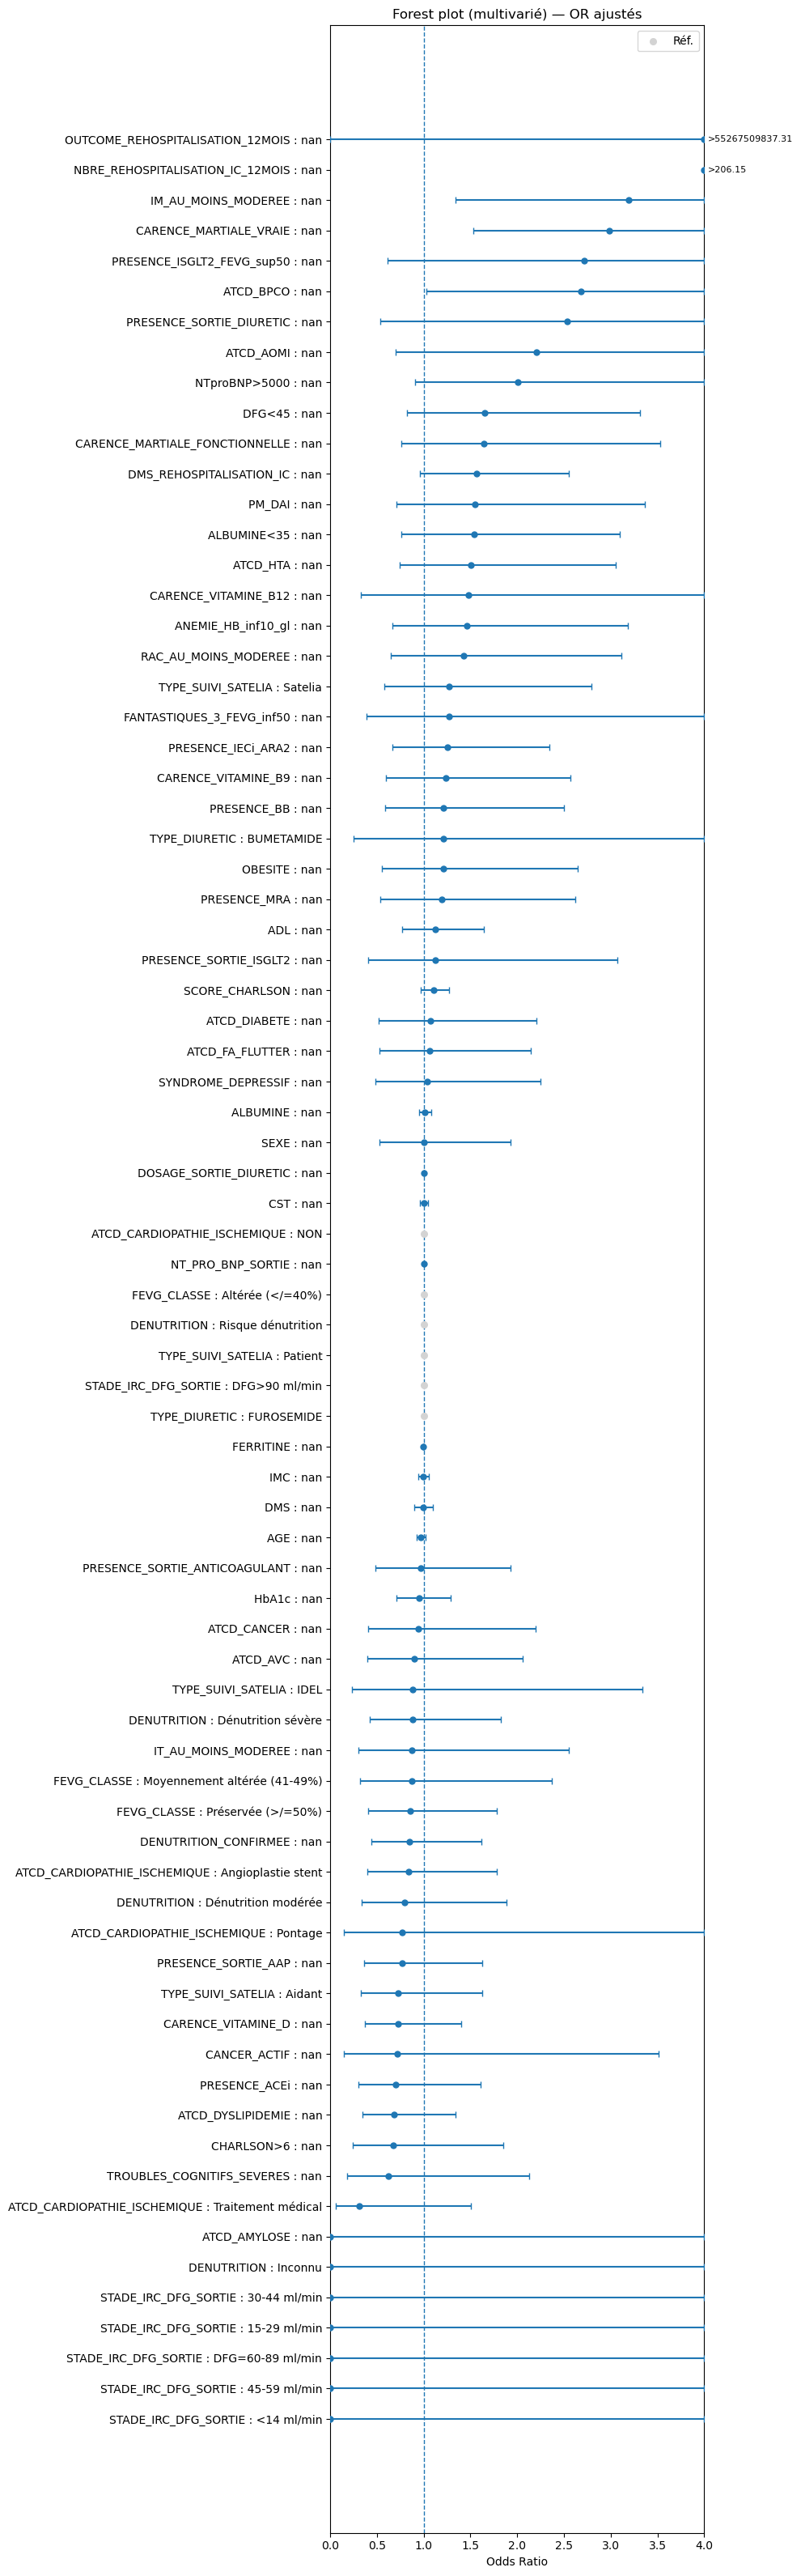

In [52]:
# Multivarié
plot_forest_linear(df, var_col, level_col, or_multi, (lo_m, up_m),
                   title=f"Forest plot (multivarié) — OR ajustés",
                   threshold=THRESHOLD, color="tab:blue")

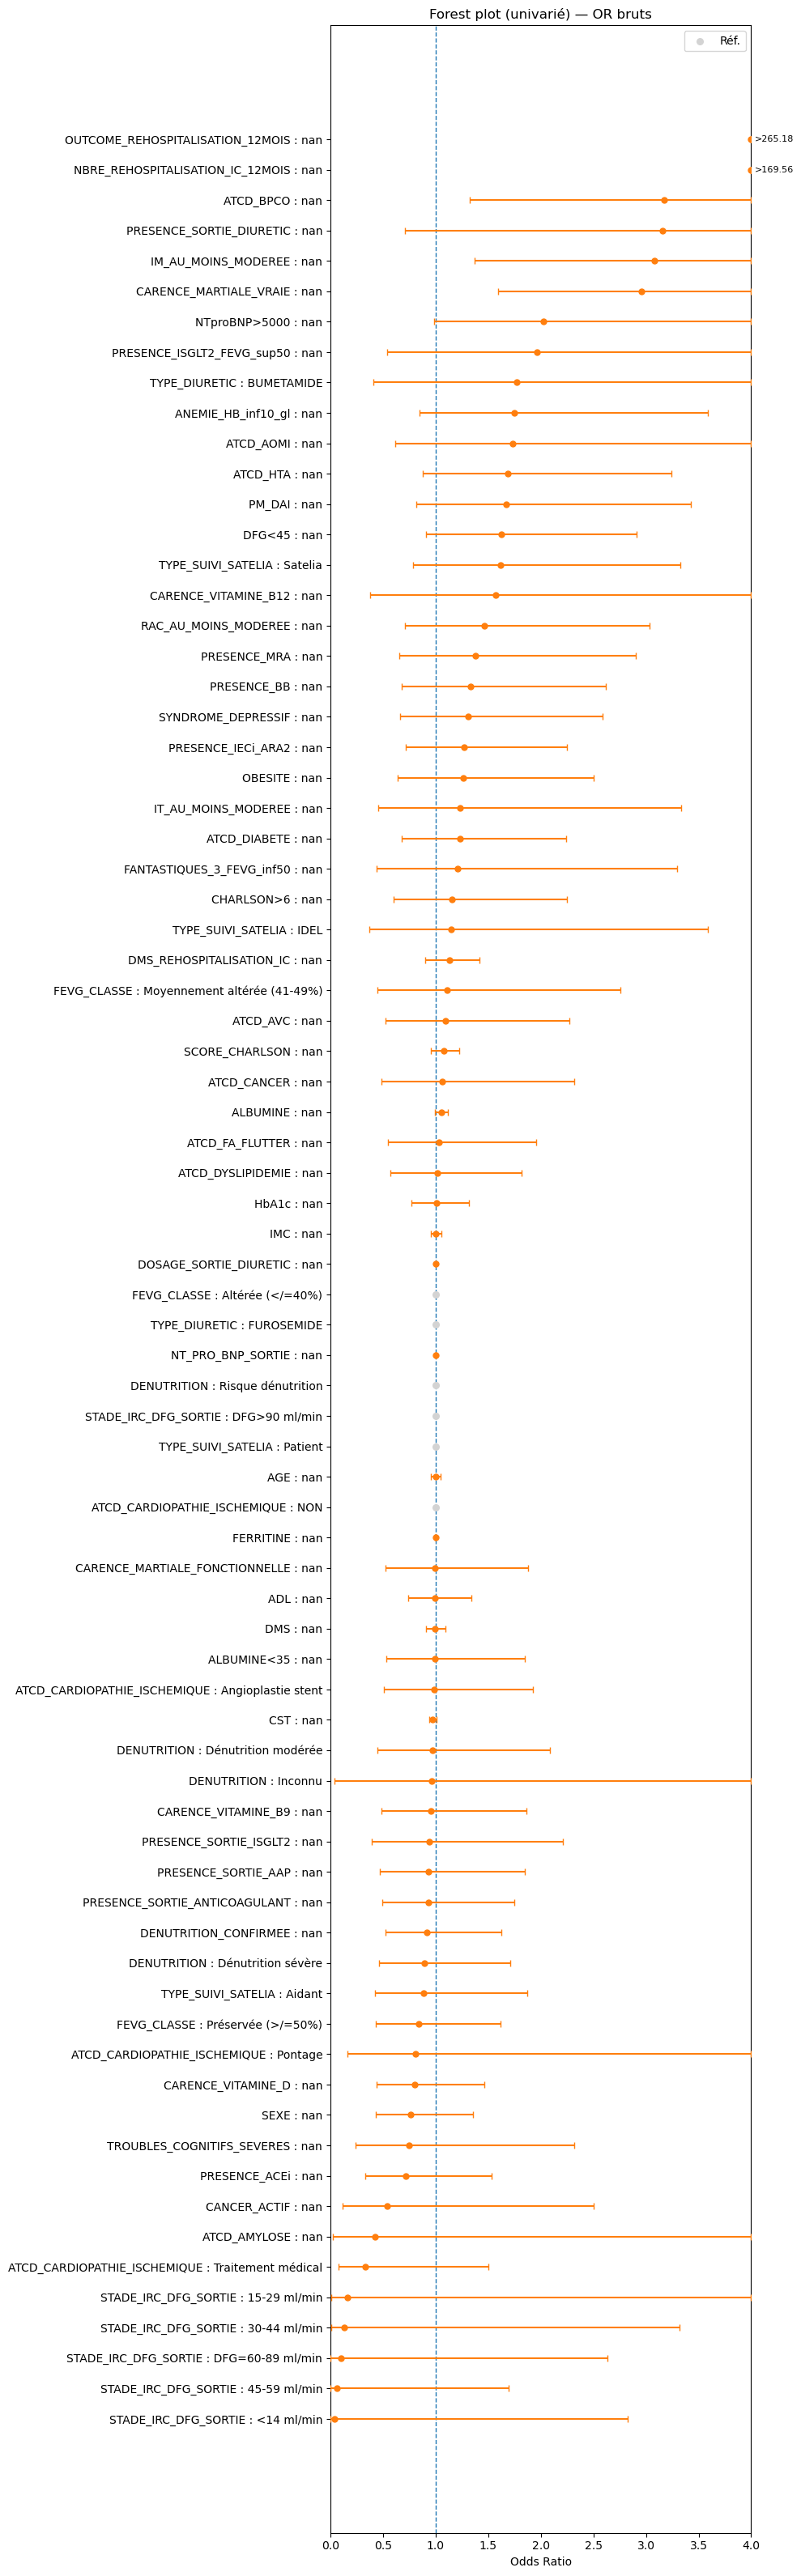

In [53]:
# Forest univarié (OR bruts)
plot_forest_linear(df, var_col, level_col, or_uni, (lo_u, up_u),
                   title=f"Forest plot (univarié) — OR bruts",
                   threshold=THRESHOLD, color="tab:orange")

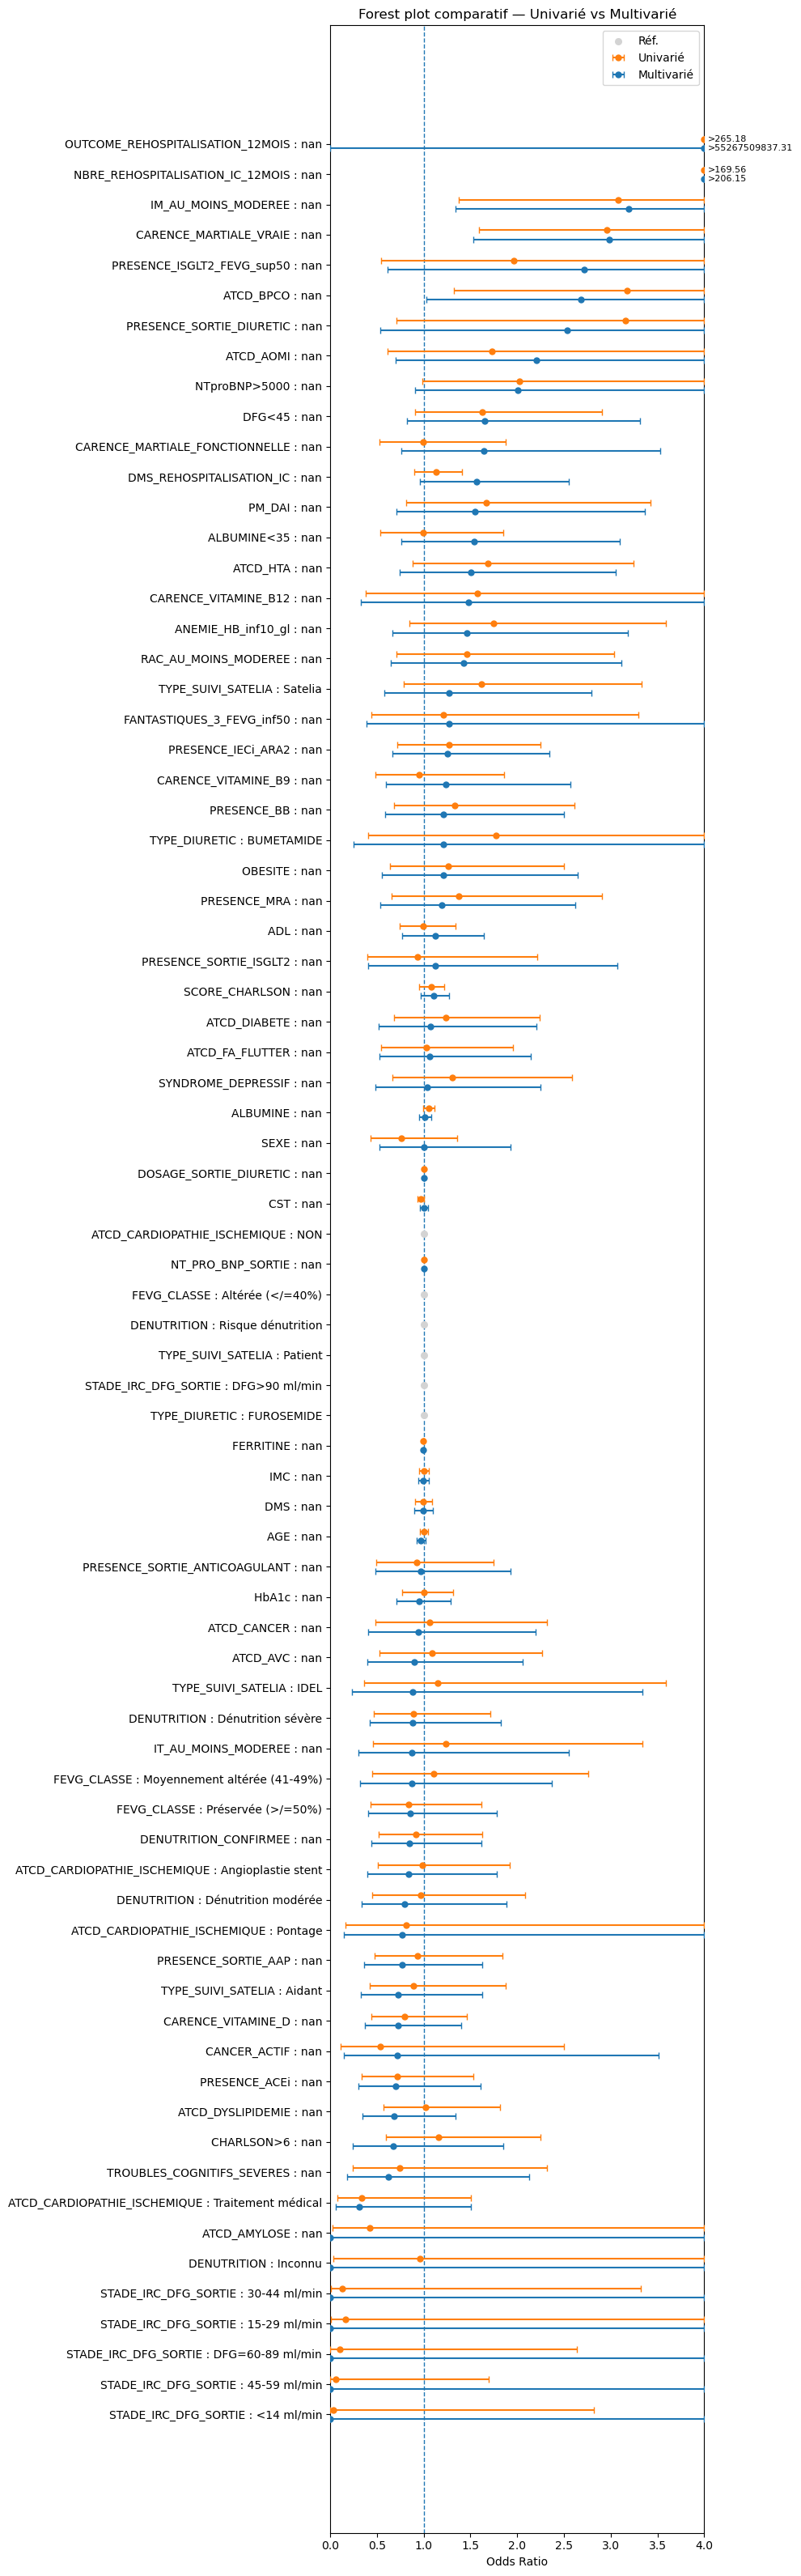

In [54]:
# Comparatif uni vs multi (2 couleurs)
plot_forest_combined_linear(
    df, var_col, level_col,
    or_uni, or_multi,
    (lo_u, up_u), (lo_m, up_m),
    title=f"Forest plot comparatif — Univarié vs Multivarié",
    threshold=THRESHOLD,
    colors=("tab:orange","tab:blue")
)